In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size=tokenizer.vocab_size+1

# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format("torch")  

device="cuda" if torch.cuda.is_available() else "cpu"

Repo card metadata block was not found. Setting CardData to empty.


In [2]:
from continous_diffusion import DiffusionModel

model=DiffusionModel(embed_dim=128,
                     qkv_dim=1024,
                     num_heads=8,
                     cond_dim=16,
                     n_blocks=8,
                     vocab_size=vocab_size,
                     device=device
                     )

print(model.n_parameters)

4461088


In [3]:
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=256, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

# Learning-rate scheduling
from torch.optim.lr_scheduler import SequentialLR, ConstantLR, LinearLR, ExponentialLR
warmup=LinearLR(optimizer,1e-3,1,5)
decay=ExponentialLR(optimizer,gamma=0.9)
scheduler=SequentialLR(optimizer,[warmup,decay],milestones=[6])

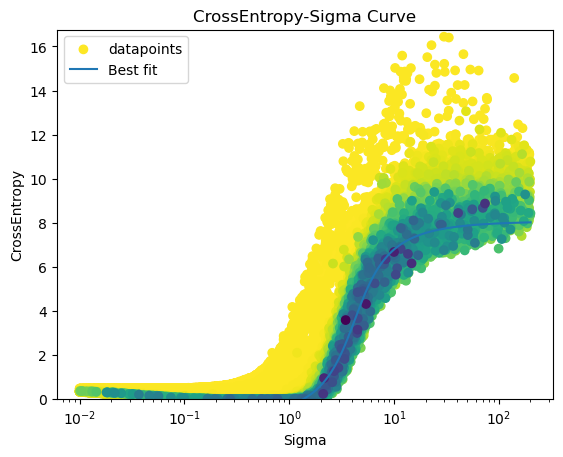

lr: [2.0589113209464913e-05]
Step: 1050,  Loss: 3.454197883605957
Step: 1051,  Loss: 3.3678550720214844
Step: 1052,  Loss: 3.3132340908050537
Step: 1053,  Loss: 3.488947629928589
Step: 1054,  Loss: 3.3946480751037598
Step: 1055,  Loss: 3.5194852352142334
Step: 1056,  Loss: 3.5706310272216797
Step: 1057,  Loss: 3.3560962677001953
Step: 1058,  Loss: 3.255856513977051
Step: 1059,  Loss: 3.383979320526123
Step: 1060,  Loss: 3.340902328491211
Step: 1061,  Loss: 3.8306891918182373
Step: 1062,  Loss: 3.4773013591766357
Step: 1063,  Loss: 3.815760850906372
Step: 1064,  Loss: 3.616791248321533
Step: 1065,  Loss: 3.7865614891052246
Step: 1066,  Loss: 3.4283206462860107
Step: 1067,  Loss: 3.5611796379089355
Step: 1068,  Loss: 3.257357597351074
Step: 1069,  Loss: 3.6059136390686035
Step: 1070,  Loss: 3.834843397140503
Step: 1071,  Loss: 3.6880593299865723
Step: 1072,  Loss: 3.660404682159424
Step: 1073,  Loss: 3.5622289180755615
Step: 1074,  Loss: 3.45182466506958
Step: 1075,  Loss: 3.165113687515

KeyboardInterrupt: 

In [4]:
schedule_update_frequency=500

from IPython.display import clear_output
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  
        tokens = batch['input_ids'].to(device)
        x,sigma,attn_mask=model.make_sample(tokens)
        prediction=model(x,sigma,attn_mask)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed

        if i%schedule_update_frequency==0 and i!=0:
            model.schedule.update_optimal_parameters()

        if i%50==0 and i!=0:
            scheduler.step()
            clear_output(wait=True) 
            model.schedule.plot_entropy_time_curve()
            print(f"lr: {scheduler.get_last_lr()}")

        print(f"Step: {i},  Loss: {loss.item()}")


In [10]:
out_embeddings=model.generate(1,64,1000,device=device)

100%|██████████| 999/999 [00:04<00:00, 227.91it/s]


In [12]:
from torch.distributions.categorical import Categorical

logits=model.un_embedder(out_embeddings)
distrubution=Categorical(logits=logits)

sample=distrubution.sample()
tokenizer.batch_decode(sample)

['reductions proposing creative responds skins milos–ส levi trafficking的lidetaff 国 saharan whitenti rid themed inspection jem acidic 松 bhutan cut [unused10]baurst motorola fragmented recent opens wagons capsuleyme downfallcuit fairchild lobesnintation football brest billions aviation angles complement downloadable fordham 1624 divorce wide greene blocking marsden sullivan blink amidst tray 84 follow mistaken 272oot']

In [ ]:
model.schedule.optimal_parameters

Parameter containing:
tensor([ 0.1884,  0.1834,  3.7468, -1.0581])